In [ ]:
# # List all directories and files in the current working directory
# for root, dirs, files in os.walk('.'):
#     print("Root directory:", root)
#     print("Subdirectories:", dirs)
#     print("Files:", files)
#     break  # Stop after the first level to avoid printing too much

In [1]:
import os
os.chdir("../")    #commment after first run


In [2]:
#imports
import dask.distributed
import pystac_client
import planetary_computer
import stackstac 
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
import geopandas as gpd
from src.utils import gen_chips

In [3]:
print(os.getcwd())
#should be /home/benchuser/code

/home/benchuser/code


In [4]:
#os.chdir("/home/benchuser/code")

In [5]:
#config setup
import yaml
with open("notebooks/config.yml", "r") as file:
    config = yaml.safe_load(file)
print(config)  # Check the structure of the dictionary


{'sentinel_2': {'collection': 'sentinel-2-l2a', 'time_ranges': ['2023-01-01/2023-03-31', '2023-04-01/2023-06-30', '2023-07-01/2023-09-30', '2023-10-01/2023-12-31'], 'cloud_cover': 1, 'bands': ['B02', 'B03', 'B04', 'B08', 'B11', 'B12'], 'resolution': 10}, 'land_cover': {'collection': 'io-lulc-annual-v02', 'year': '2023-01-02/2023-12-31'}, 'chips': {'sample_size': 100, 'chip_size': 224}, 'output': {'directory': 'notebooks/test_output_dump', 'naming_convention': 's2_{season}_{index:05}.tif'}, 'metadata': {'file': 'metadata.csv'}}


In [6]:
# Sentinel-2 settings
s2_collection = config["sentinel_2"]["collection"]
s2_date_ranges = config["sentinel_2"]["time_ranges"]
s2_bands = config["sentinel_2"]["bands"]
s2_resolution = config["sentinel_2"]["resolution"]
cloud_cover_threshold = config["sentinel_2"]["cloud_cover"]  # Max allowed cloud cover

# Land Cover settings
lc_collection = config["land_cover"]["collection"]
lc_year = config["land_cover"]["year"]  # Year of LC dataset

# Chip settings
sample_size = config["chips"]["sample_size"]  # Grid size for homogeneity check
chip_size = config["chips"]["chip_size"]  # Output chip size

# Output settings
output_dir = config["output"]["directory"]
chip_naming_convention = config["output"]["naming_convention"]

# Metadata settings
metadata_file = config["metadata"]["file"]

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Define seasons for indexing
seasons = ["JFM", "AMJ", "JAS", "OND"]

aoi_gdf = gpd.read_file("data/urbans.geojson") # or "data/aois.geojson"


In [7]:
#dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=8, threads_per_worker=1)
client = Client(cluster)
print(client.dashboard_link)

http://127.0.0.1:8787/status


2025-02-14 20:02:40,532 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('getitem-3963f6ca4906d1f282988384b45b718d', 6, 0) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7f246a604cc0>, (('rechunk-merge-rechunk-split-reshape-getitem-3963f6ca4906d1f282988384b45b718d', 6, 0),), {})
new run_spec: (<function execute_task at 0x7f246a604cc0>, (('fetch_raster_window-rechunk-merge-rechunk-split-reshape-getitem-3963f6ca4906d1f282988384b45b718d', 6, 0),), {})
old token: ('tuple', (('913ceb5b5beb463a9010ec0790bc30002ca34164', []), ('tuple', (('tuple', ('rechunk-merge-rechunk-split

In [19]:
def search_s2_scenes(aoi, date_range):
    """
    Searches for Sentinel-2 scenes within the AOI and date range.
    Adds debugging info to identify missing data issues.
    """

    #print(f"\n Searching Sentinel-2 for AOI {aoi.geometry.bounds} during {date_range}")

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )

    # Print the exact query parameters
    # print(f"Querying collection: 'sentinel-2-l2a'")
    #print(f"Bounding Box: {aoi.geometry.bounds}")
    #print(f"Date Range: {date_range}")
    # print(f"Cloud Cover Filter: < {1}%")
    
    s2_search = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=aoi.geometry.bounds, 
        datetime=date_range,
        query={"eo:cloud_cover": {"lt": 1}},  # Fix query syntax to dictionary
        sortby=["+properties.eo:cloud_cover"],  # Sort by least cloud cover
        max_items=1,  # Increase items to check for any available data
    )

    # Print found items
    items = s2_search.item_collection()
    #print(f"Found {len(items)} Sentinel-2 scenes")
    
    # Print full STAC item properties for debugging
    # if len(items) > 0:
    #     print(f"First Scene ID: {items[0].id}")
    #     print(f"First Scene EPSG: {items[0].properties.get('proj:epsg', 'Unknown')}")
    #     print(f"Acquisition Date: {items[0].properties.get('datetime', 'Unknown')}")
    #     print(f"Cloud Cover: {items[0].properties.get('eo:cloud_cover', 'Unknown')}")
    # else:
    #     print(f"No Sentinel-2 data found for this AOI and date range!")

    return list(items)  # Convert ItemCollection to a list of Items
def search_lc_scene(bbox, lc_date_range):
    #print(f"Searching for Land Cover scenes within {lc_date_range} for bbox {bbox}")
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )
    lc_search = catalog.search(
        collections=["io-lulc-annual-v02"],
        bbox=bbox,
        datetime=lc_date_range,
    )
    items = lc_search.item_collection()
    #print(f"Found {len(items)} Land Cover scenes")
    return list(items)  # Convert ItemCollection to a list of Items

def stack_s2_data(s2_items, s2_bands):
    print("\nChecking available assets in Sentinel-2 items...")
    for i, item in enumerate(s2_items[:3]):
        print(f"Scene {i + 1}: {item.id}")
        #print(f"Available assets: {list(item.assets.keys())}")

    valid_bands = [band for band in s2_bands if all(band in item.assets for item in s2_items)]
    missing_bands = [band for band in s2_bands if band not in valid_bands]
    if missing_bands:
        print(f"Warning: Missing bands {missing_bands}. These will be excluded from stacking.")

    try:
        s2_stack = stackstac.stack(
            s2_items,
            assets=valid_bands,
            epsg=s2_items[0].properties["proj:epsg"],
            resolution=10,
            fill_value=np.nan#,
            #dtype="float32"
        )

        #print(f"Stacked Sentinel-2 bands: {list(s2_stack.coords['band'].values)}")
        #print(s2_stack.dims)  # Prints available dimensions
        #print(s2_stack.coords)  # Prints available coordinates

        return s2_stack

    except Exception as e:
        print(f"Error stacking Sentinel-2 data: {e}")
        return None
        
def stack_lc_data(lc_items, s2_epsg):
    if not lc_items:
        print("No Land Cover data found.")
        return None
    try:
        print("Stacking Land Cover images...")
        stacked_data = stackstac.stack(
            lc_items,
            dtype=np.ubyte,
            fill_value=255,
            sortby_date=False,
            epsg=s2_epsg,
            resolution=10,
            bounds_latlon=s2_items[0].bbox,
        ).squeeze()

        stacked_data = stacked_data.chunk(chunks={"x": sample_size, "y": sample_size})
        print("Stacked LC data shape:", stacked_data.shape)
        #print(f"Chunk sizes: {stacked_data.chunks}")   #uncomment for big chunk size 

        return stacked_data

    except Exception as e:
        print(f"Error stacking Land Cover data: {e}")
        return None


def has_missing_values(array):
    """Check if the given array contains NaN values and print only when necessary."""
    has_nan = array.isnull().any().compute()
    if has_nan:
        print("Warning: Missing values detected in the chip!")
    return has_nan

def process_chips(aoi, s2_stack, lc_stack, output_dir, global_index, chip_dict, sample_size, acquisition_date):
    chip_count = 0
    print(f"Processing chips for AOI at {aoi.geometry.bounds} for date {acquisition_date}")

    def unique_class(window, axis=None, **kwargs):
        return np.all(window == window[0, 0], axis=axis)

    new_x = (lc_stack.shape[0] // sample_size) * sample_size
    new_y = (lc_stack.shape[1] // sample_size) * sample_size

    lc_stack_trimmed = lc_stack.isel(
        x=slice(0, new_x), 
        y=slice(0, new_y)
    ).assign_coords(
        x=lc_stack.coords['x'].isel(x=slice(0, new_x)),
        y=lc_stack.coords['y'].isel(y=slice(0, new_y))
    )

    lc_uniqueness = lc_stack_trimmed.coarsen(x=sample_size, y=sample_size, boundary="trim").reduce(unique_class)

    for i in range(0, lc_stack_trimmed.shape[0] - sample_size + 1, sample_size):
        for j in range(0, lc_stack_trimmed.shape[1] - sample_size + 1, sample_size):
            if not lc_uniqueness.isel(x=i // sample_size, y=j // sample_size):
                continue

            s2_chip = s2_stack.isel(x=slice(i, i + sample_size), y=slice(j, j + sample_size))
            lc_chip = lc_stack_trimmed.isel(x=slice(i, i + sample_size), y=slice(j, j + sample_size))

            if s2_chip.isnull().all() or lc_chip.isnull().all():
                print(f"Skipping chip {global_index}: Empty dataset (NoDataInBounds)")
                continue

            chip_metadata = {
                "aoi_bounds": aoi.geometry.bounds,
                "date": acquisition_date,
                "coords": (i, j)
            }

            chip_dict[(i, j, acquisition_date)] = (s2_chip, lc_chip, chip_metadata)

            chip_name = f"s2_{global_index:05}.tif"
            lc_chip.rio.to_raster(os.path.join(output_dir, f"lc_{chip_name}"))
            s2_chip.squeeze().drop_vars([dim for dim in s2_chip.dims if dim not in ['band', 'x', 'y']], errors="ignore").rio.to_raster(os.path.join(output_dir, chip_name))

            print(f"Saved chip {chip_name}")

            global_index += 1
            chip_count += 1

            if chip_count >= 4:
                print(f"Reached 4 chips for this time period. Moving to next time period.")
                chip_count = 0
                continue

    print(f"Finished processing for date {acquisition_date}.")
    return global_index





# Updated plotting function
def plot_chips(chip_dict, chip_indices):
    import matplotlib.pyplot as plt

    selected_chips = [chip_dict[idx] for idx in chip_indices if idx in chip_dict]

    if not selected_chips:
        print("No chips selected for plotting.")
        return

    num_chips = len(selected_chips)
    num_rows = (num_chips + 3) // 4  # Calculate the number of rows for 4 chips per row

    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 6 * num_rows))
    axes = axes.flatten() if num_rows > 1 else [axes]

    for idx, (s2_chip, lc_chip, metadata) in enumerate(selected_chips):
        if s2_chip is None or lc_chip is None:
            print(f"Skipping chip {chip_indices[idx]}: Missing data.")
            continue

        rgb_image = s2_chip.isel(time=0).sel(band=["B04", "B03", "B02"]).transpose("y", "x", "band").compute()
        axes[idx].imshow(rgb_image.clip(0, 3000) / 3000)
        axes[idx].set_title(f"Chip {idx+1}\nDate: {metadata['date']}\nCoords: {metadata['coords']}")
        axes[idx].axis("off")

    for ax in axes[num_chips:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()



In [16]:
global_index = 0
chip_dict = {}  # Initialize chip dictionary
# Updated loop logic in main processing:
for index, aoi in aoi_gdf.iterrows():
    for date_range in s2_date_ranges:
        s2_items = search_s2_scenes(aoi, date_range)
        if not s2_items:
            continue
        expected_bands = ["B02", "B03", "B04", "B08", "B11", "B12"]  # Includes RGB & SWIR bands
        acquisition_date = s2_items[0].properties.get('datetime', 'N/A')
        s2_stack = stack_s2_data(s2_items, expected_bands)
        if s2_stack is None:
            continue

        lc_items = search_lc_scene(s2_items[0].bbox, lc_year)
        if not lc_items:
            continue

        lc_stack = stack_lc_data(lc_items, s2_stack.rio.crs.to_epsg())
        if lc_stack is None:
            continue

        global_index = process_chips(aoi, s2_stack, lc_stack, output_dir, global_index, chip_dict, sample_size, acquisition_date)

    # Stop after one AOI to check outputs
    # if global_index > 4:
    #     break  
    # #break


Checking available assets in Sentinel-2 items...
Scene 1: S2B_MSIL2A_20230118T083159_R021_T36RUU_20230120T032254


/opt/conda/envs/gfm_bench/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Stacking Land Cover images...
Stacked LC data shape: (11272, 11273)
Processing chips for AOI at (31.20416267326229, 30.02337142235983, 31.280433633102717, 30.060612342021983) for date 2023-01-18T08:31:59.024000Z


/opt/conda/envs/gfm_bench/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Saved chip s2_00000.tif
Saved chip s2_00001.tif
Saved chip s2_00002.tif
Saved chip s2_00003.tif
Reached 4 chips for this time period. Moving to next time period.
Saved chip s2_00004.tif
Saved chip s2_00005.tif
Saved chip s2_00006.tif
Saved chip s2_00007.tif
Reached 4 chips for this time period. Moving to next time period.
Saved chip s2_00008.tif
Saved chip s2_00009.tif
Saved chip s2_00010.tif
Saved chip s2_00011.tif
Reached 4 chips for this time period. Moving to next time period.
Saved chip s2_00012.tif
Saved chip s2_00013.tif
Saved chip s2_00014.tif
Saved chip s2_00015.tif
Reached 4 chips for this time period. Moving to next time period.
Saved chip s2_00016.tif
Saved chip s2_00017.tif
Saved chip s2_00018.tif
Saved chip s2_00019.tif
Reached 4 chips for this time period. Moving to next time period.
Saved chip s2_00020.tif
Saved chip s2_00021.tif
Saved chip s2_00022.tif
Saved chip s2_00023.tif
Reached 4 chips for this time period. Moving to next time period.
Saved chip s2_00024.tif
Save

2025-02-14 20:25:06,984 - distributed.worker - ERROR - Compute Failed
Key:       ('asset_table_to_reader_and_window-fetch_raster_window-getitem-all-a5bf2721b38d89c05ee51898fdf734bb', 0, 4, 0, 0)
State:     executing
Function:  execute_task
args:      ((subgraph_callable-20e91caf8978315b537d4f4978946062, (<function getitem at 0x7fc9be0afc40>, (subgraph_callable-35da13da46de9471d08fdc74be7ecc42, (subgraph_callable-ac950f0a467ff1f93d708030137a0eee, array([[('https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/36/R/UU/2023/01/18/S2B_MSIL2A_20230118T083159_N0400_R021_T36RUU_20230120T032254.SAFE/GRANULE/L2A_T36RUU_A030649_20230118T083259/IMG_DATA/R20m/T36RUU_20230118T083159_B11_20m.tif?st=2025-02-13T19%3A38%3A27Z&se=2025-02-14T20%3A23%3A27Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-02-14T19%3A31%3A59Z&ske=2025-02-21T19%3A31%3A59Z&sks=b&skv=2024-05-04&sig=RGxoPO2h7NcrcbhW9FRjo0d07ThDlRvaw%2BUJ%2Bps8vPY%3D', [ 

RuntimeError: Error reading Window(col_off=3072, row_off=0, width=1024, height=1024) from 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/36/R/UU/2023/01/18/S2B_MSIL2A_20230118T083159_N0400_R021_T36RUU_20230120T032254.SAFE/GRANULE/L2A_T36RUU_A030649_20230118T083259/IMG_DATA/R20m/T36RUU_20230118T083159_B11_20m.tif?st=2025-02-13T19%3A38%3A27Z&se=2025-02-14T20%3A23%3A27Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-02-14T19%3A31%3A59Z&ske=2025-02-21T19%3A31%3A59Z&sks=b&skv=2024-05-04&sig=RGxoPO2h7NcrcbhW9FRjo0d07ThDlRvaw%2BUJ%2Bps8vPY%3D': RasterioIOError('Read failed. See previous exception for details.')

In [17]:
print(chip_dict.keys())

dict_keys([(0, 900, '2023-01-18T08:31:59.024000Z'), (0, 3000, '2023-01-18T08:31:59.024000Z'), (0, 5200, '2023-01-18T08:31:59.024000Z'), (0, 5300, '2023-01-18T08:31:59.024000Z'), (0, 5700, '2023-01-18T08:31:59.024000Z'), (0, 5800, '2023-01-18T08:31:59.024000Z'), (0, 5900, '2023-01-18T08:31:59.024000Z'), (100, 0, '2023-01-18T08:31:59.024000Z'), (100, 300, '2023-01-18T08:31:59.024000Z'), (100, 5200, '2023-01-18T08:31:59.024000Z'), (100, 5600, '2023-01-18T08:31:59.024000Z'), (100, 5900, '2023-01-18T08:31:59.024000Z'), (500, 6000, '2023-01-18T08:31:59.024000Z'), (600, 2600, '2023-01-18T08:31:59.024000Z'), (600, 6000, '2023-01-18T08:31:59.024000Z'), (800, 0, '2023-01-18T08:31:59.024000Z'), (800, 200, '2023-01-18T08:31:59.024000Z'), (800, 6300, '2023-01-18T08:31:59.024000Z'), (800, 6500, '2023-01-18T08:31:59.024000Z'), (1100, 0, '2023-01-18T08:31:59.024000Z'), (1100, 300, '2023-01-18T08:31:59.024000Z'), (1100, 400, '2023-01-18T08:31:59.024000Z'), (1100, 1200, '2023-01-18T08:31:59.024000Z'), (

In [32]:
#print(chip_dict)

2025-02-14 20:31:30,604 - distributed.worker - ERROR - Compute Failed
Key:       ('asset_table_to_reader_and_window-fetch_raster_window-getitem-196fcd605583d5000de4a6af7f328e9c', 0, 0, 0)
State:     executing
Function:  execute_task
args:      ((<function getitem at 0x7f8c131382c0>, (subgraph_callable-35da13da46de9471d08fdc74be7ecc42, (subgraph_callable-ac950f0a467ff1f93d708030137a0eee, array([[('https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/36/R/UU/2023/01/18/S2B_MSIL2A_20230118T083159_N0400_R021_T36RUU_20230120T032254.SAFE/GRANULE/L2A_T36RUU_A030649_20230118T083259/IMG_DATA/R10m/T36RUU_20230118T083159_B02_10m.tif?st=2025-02-13T19%3A38%3A27Z&se=2025-02-14T20%3A23%3A27Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-02-14T19%3A31%3A59Z&ske=2025-02-21T19%3A31%3A59Z&sks=b&skv=2024-05-04&sig=RGxoPO2h7NcrcbhW9FRjo0d07ThDlRvaw%2BUJ%2Bps8vPY%3D', [ 300000., 3290220.,  409800., 3400020.], [1., 0.])]],
      d

RuntimeError: Error reading Window(col_off=0, row_off=0, width=1024, height=1024) from 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/36/R/UU/2023/01/18/S2B_MSIL2A_20230118T083159_N0400_R021_T36RUU_20230120T032254.SAFE/GRANULE/L2A_T36RUU_A030649_20230118T083259/IMG_DATA/R10m/T36RUU_20230118T083159_B02_10m.tif?st=2025-02-13T19%3A38%3A27Z&se=2025-02-14T20%3A23%3A27Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-02-14T19%3A31%3A59Z&ske=2025-02-21T19%3A31%3A59Z&sks=b&skv=2024-05-04&sig=RGxoPO2h7NcrcbhW9FRjo0d07ThDlRvaw%2BUJ%2Bps8vPY%3D': RasterioIOError('Read failed. See previous exception for details.')

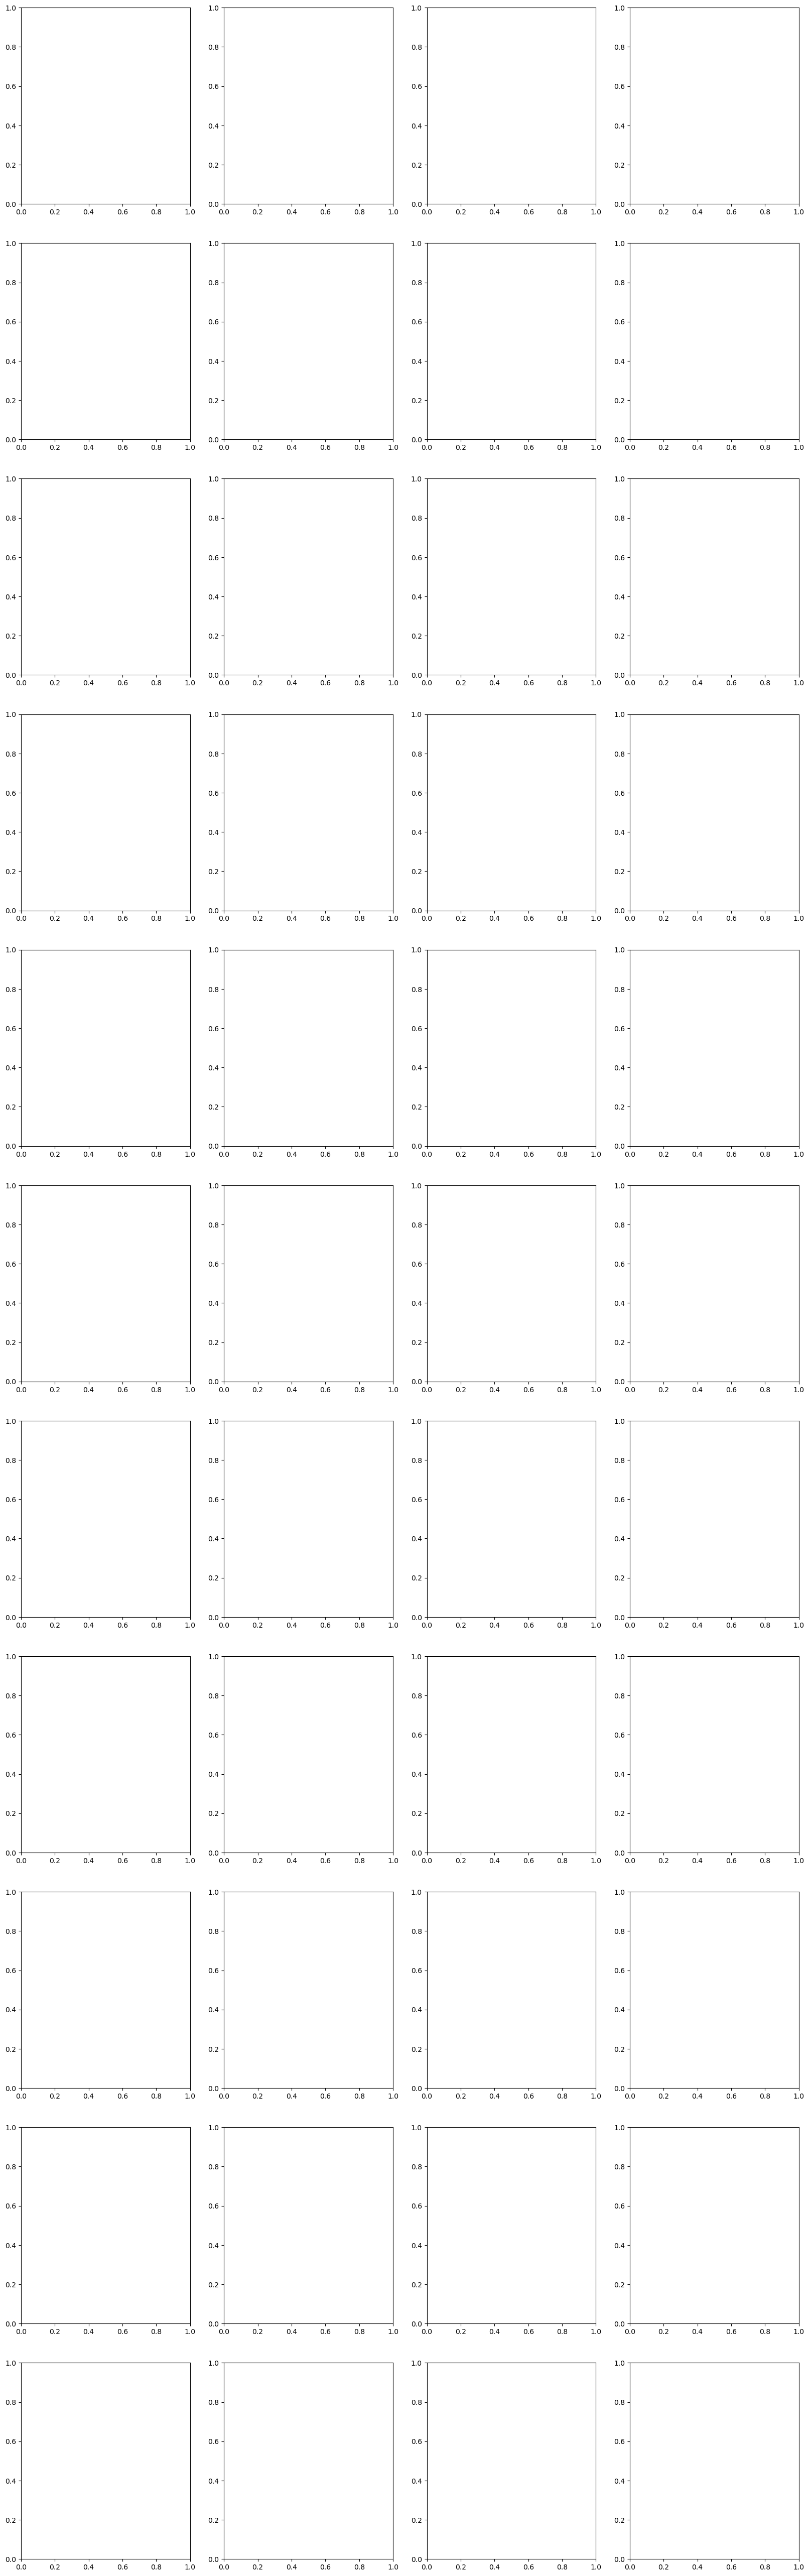

In [20]:
import matplotlib.pyplot as plt
plot_chips(chip_dict, [(0, 900, '2023-01-18T08:31:59.024000Z'), (0, 3000, '2023-01-18T08:31:59.024000Z'), (0, 5200, '2023-01-18T08:31:59.024000Z'), (0, 5300, '2023-01-18T08:31:59.024000Z'), (0, 5700, '2023-01-18T08:31:59.024000Z'), (0, 5800, '2023-01-18T08:31:59.024000Z'), (0, 5900, '2023-01-18T08:31:59.024000Z'), (100, 0, '2023-01-18T08:31:59.024000Z'), (100, 300, '2023-01-18T08:31:59.024000Z'), (100, 5200, '2023-01-18T08:31:59.024000Z'), (100, 5600, '2023-01-18T08:31:59.024000Z'), (100, 5900, '2023-01-18T08:31:59.024000Z'), (500, 6000, '2023-01-18T08:31:59.024000Z'), (600, 2600, '2023-01-18T08:31:59.024000Z'), (600, 6000, '2023-01-18T08:31:59.024000Z'), (800, 0, '2023-01-18T08:31:59.024000Z'), (800, 200, '2023-01-18T08:31:59.024000Z'), (800, 6300, '2023-01-18T08:31:59.024000Z'), (800, 6500, '2023-01-18T08:31:59.024000Z'), (1100, 0, '2023-01-18T08:31:59.024000Z'), (1100, 300, '2023-01-18T08:31:59.024000Z'), (1100, 400, '2023-01-18T08:31:59.024000Z'), (1100, 1200, '2023-01-18T08:31:59.024000Z'), (1100, 1300, '2023-01-18T08:31:59.024000Z'), (1100, 5300, '2023-01-18T08:31:59.024000Z'), (1800, 1500, '2023-01-18T08:31:59.024000Z'), (1800, 6300, '2023-01-18T08:31:59.024000Z'), (2400, 200, '2023-01-18T08:31:59.024000Z'), (2400, 5100, '2023-01-18T08:31:59.024000Z'), (2500, 200, '2023-01-18T08:31:59.024000Z'), (2500, 1100, '2023-01-18T08:31:59.024000Z'), (2500, 5800, '2023-01-18T08:31:59.024000Z'), (2600, 400, '2023-01-18T08:31:59.024000Z'), (2600, 500, '2023-01-18T08:31:59.024000Z'), (2600, 1200, '2023-01-18T08:31:59.024000Z'), (2600, 5500, '2023-01-18T08:31:59.024000Z'), (2600, 5800, '2023-01-18T08:31:59.024000Z'), (2700, 4300, '2023-01-18T08:31:59.024000Z'), (2800, 800, '2023-01-18T08:31:59.024000Z'), (2800, 1300, '2023-01-18T08:31:59.024000Z'), (2800, 1400, '2023-01-18T08:31:59.024000Z'), (2900, 400, '2023-01-18T08:31:59.024000Z'), (2900, 1800, '2023-01-18T08:31:59.024000Z')])



In [ ]:
#print(s2_stack)

In [ ]:
#print(s2_stack.isel(band=0))

In [ ]:
#print("First four chips content:", first_four_chips)

In [ ]:
#print(chip_dict)